In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

## 1. Loading and Normalizing CIFAR 10

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])    #normalize. how to determine the params?

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


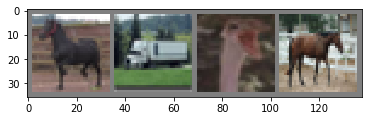

horse truck  bird horse


In [23]:
import matplotlib.pyplot as plt
import numpy as np

#functions to show an image

def imshow(img):
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a CNN

In [24]:
import torch.nn as nn
import torch.nn.functional as F

#gpu or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):    #similar to leNet structure
    def __init__(self):
        super(Net, self).__init__()    # what is super doing here
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)   # how to you determine the params
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)


## 3. Define a Loss function and optimizer

In [27]:
# cross-Entropy loss and SGD with momentun

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

optimizer = optim.Adam(net.parameters(), lr = 0.002, betas=(0.9, 0.999))



## 4. Train the network

In [28]:
# loop over our data iterator
# and feed the inputs to the network and optimize
# try using gpu instead

for epoch in range(2):    # loop over the dataset multiple times
    start = time.time()   #initializes the timer
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #zero the gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %3f, time %.1f sec' % 
                  (epoch + 1, i + 1, running_loss / 2000, time.time() - start))
            running_loss = 0.0

print('Finished Training')
            
#Adam this time

[1,  2000] loss: 1.449821, time 18.2 sec
[1,  4000] loss: 1.444329, time 34.4 sec
[1,  6000] loss: 1.433528, time 50.4 sec
[1,  8000] loss: 1.401187, time 66.7 sec
[1, 10000] loss: 1.407537, time 82.8 sec
[1, 12000] loss: 1.379319, time 98.9 sec
[2,  2000] loss: 1.302206, time 20.5 sec
[2,  4000] loss: 1.309634, time 37.9 sec
[2,  6000] loss: 1.303259, time 54.3 sec
[2,  8000] loss: 1.314100, time 70.3 sec
[2, 10000] loss: 1.259018, time 86.2 sec
[2, 12000] loss: 1.297993, time 103.3 sec
Finished Training


## 5. Test the network on the test data

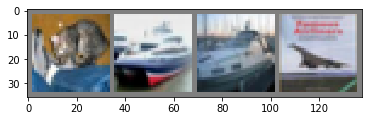

GroundTruth:    cat  ship  ship plane


In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range (4)))


In [30]:
# now lets see what the neural network thinks these examples are

images = images.to(device)   #switch to gpu mode
outputs = net(images)

# the outputs are energies(confidnece/probability?) for the 10 classes. 
# the higher the energy for a class, the more the networks thinks that the 
# image is of the particular class

_, predicted = torch.max(outputs, 1)   # _ is a placeholder variable

print('predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range (4)))

predicted:    cat   car  ship plane


In [31]:
# Now see how the newtwork performs on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  #gpu
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [32]:
# what are the classes that performed well,
# and the classes that did not perform well:

class_correct = list(0. for i in range (10))
class_total = list(0. for i in range (10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)    # torch.max(output, dim)
        c = (predicted == labels).squeeze()     # correct predictions
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
        

Accuracy of plane: 50 %
Accuracy of   car: 72 %
Accuracy of  bird: 46 %
Accuracy of   cat: 49 %
Accuracy of  deer: 38 %
Accuracy of   dog: 17 %
Accuracy of  frog: 74 %
Accuracy of horse: 57 %
Accuracy of  ship: 76 %
Accuracy of truck: 70 %
